## Modules

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,SimpleRNN
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [2]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.1
Num GPUs: 1


## Funções Uteis

In [3]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [4]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [5]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [6]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [7]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [8]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [9]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


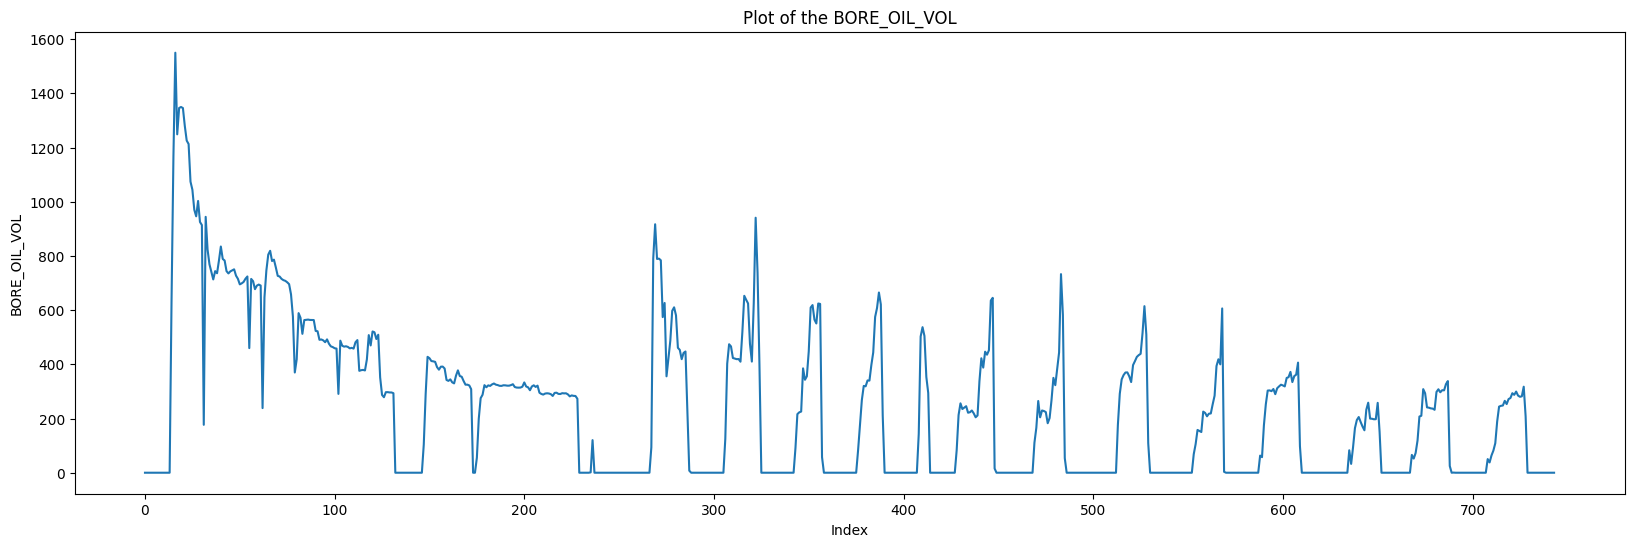

In [10]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [11]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [12]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


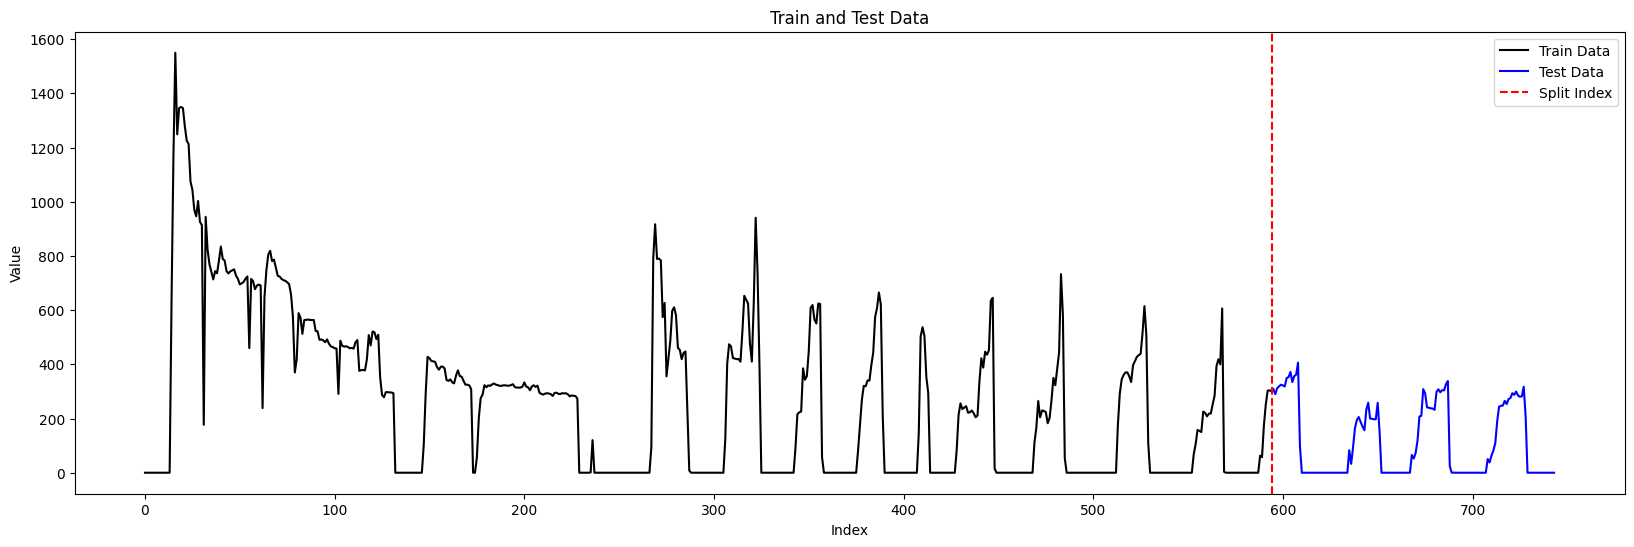

In [13]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [14]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


## Preparing the X_train, X_test, y_train and y_test

In [15]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [16]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [17]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [18]:
epochs = 500 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [19]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [20]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

# LSTM Model

In [21]:
# pip install optuna
!pip install optuna-integration

In [22]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [23]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [24]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 2, 60)  # Adjust the range as needed
    batch_size = trial.suggest_int('batch_size', 1, 20)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    Dropout_rate = trial.suggest_float('Dropout_rate', 0.1, 0.5)


    # Set the sequence length - this is the timeframe used to make a single prediction
    num_outputs = 1
    X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
    X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

    time_steps = window_size - 1
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(GRU(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
        model_LSTM.add(Dropout(Dropout_rate))
    
    model_LSTM.add(GRU(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [25]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2023-11-04 23:05:02,219] A new study created in memory with name: no-name-63ef2d06-1ee2-4168-9586-49593be903a9


In [26]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=250)



INFO:tensorflow:Assets written to: ram://3f31141c-b922-484b-bb92-760214d3172e/assets


INFO:tensorflow:Assets written to: ram://3f31141c-b922-484b-bb92-760214d3172e/assets
[I 2023-11-04 23:09:25,801] Trial 0 finished with value: 0.006812696810811758 and parameters: {'window_size': 28, 'batch_size': 15, 'n_lstm_layers': 7, 'lstm_units': 147, 'learning_rate': 0.0005640166351336888, 'Dropout_rate': 0.28801731925455754}. Best is trial 0 with value: 0.006812696810811758.


INFO:tensorflow:Assets written to: ram://53ffc966-1a5a-4c51-b75d-eb414cc085c4/assets


INFO:tensorflow:Assets written to: ram://53ffc966-1a5a-4c51-b75d-eb414cc085c4/assets
[I 2023-11-04 23:36:16,191] Trial 1 finished with value: 0.008815757930278778 and parameters: {'window_size': 46, 'batch_size': 6, 'n_lstm_layers': 15, 'lstm_units': 252, 'learning_rate': 0.002409405141710269, 'Dropout_rate': 0.15087672717688203}. Best is trial 0 with value: 0.006812696810811758.


INFO:tensorflow:Assets written to: ram://c0dabdb2-a7f9-45ba-a70b-66be26bcc165/assets


INFO:tensorflow:Assets written to: ram://c0dabdb2-a7f9-45ba-a70b-66be26bcc165/assets
[I 2023-11-04 23:46:24,638] Trial 2 finished with value: 0.021202251315116882 and parameters: {'window_size': 10, 'batch_size': 8, 'n_lstm_layers': 17, 'lstm_units': 43, 'learning_rate': 0.006199655606546731, 'Dropout_rate': 0.44541135311754254}. Best is trial 0 with value: 0.006812696810811758.


INFO:tensorflow:Assets written to: ram://c51ed843-fe19-4465-ac11-65cfc74c49c7/assets


INFO:tensorflow:Assets written to: ram://c51ed843-fe19-4465-ac11-65cfc74c49c7/assets
[I 2023-11-04 23:49:40,999] Trial 3 finished with value: 0.001609161263331771 and parameters: {'window_size': 57, 'batch_size': 16, 'n_lstm_layers': 4, 'lstm_units': 33, 'learning_rate': 0.0031640726407504358, 'Dropout_rate': 0.24461032061955576}. Best is trial 3 with value: 0.001609161263331771.


INFO:tensorflow:Assets written to: ram://b26715de-6a49-4993-a017-a1d61b546a5b/assets


INFO:tensorflow:Assets written to: ram://b26715de-6a49-4993-a017-a1d61b546a5b/assets
[I 2023-11-04 23:55:04,044] Trial 4 finished with value: 0.020066609606146812 and parameters: {'window_size': 24, 'batch_size': 14, 'n_lstm_layers': 10, 'lstm_units': 41, 'learning_rate': 0.0038176559470374616, 'Dropout_rate': 0.49416768501818564}. Best is trial 3 with value: 0.001609161263331771.
[I 2023-11-04 23:55:15,874] Trial 5 pruned. 
[I 2023-11-04 23:55:36,137] Trial 6 pruned. 
[I 2023-11-04 23:55:40,114] Trial 7 pruned. 
[I 2023-11-04 23:55:49,888] Trial 8 pruned. 
[I 2023-11-04 23:56:00,969] Trial 9 pruned. 


INFO:tensorflow:Assets written to: ram://1104a4d8-ca5c-402a-a3f7-61e310ac0c4a/assets


INFO:tensorflow:Assets written to: ram://1104a4d8-ca5c-402a-a3f7-61e310ac0c4a/assets
[I 2023-11-04 23:57:09,441] Trial 10 finished with value: 0.0017217211425304413 and parameters: {'window_size': 40, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 80, 'learning_rate': 0.009908273743397783, 'Dropout_rate': 0.11128338075976268}. Best is trial 3 with value: 0.001609161263331771.


INFO:tensorflow:Assets written to: ram://ad353f4e-2a26-4667-a3ff-acc3c844714f/assets


INFO:tensorflow:Assets written to: ram://ad353f4e-2a26-4667-a3ff-acc3c844714f/assets
[I 2023-11-04 23:58:17,542] Trial 11 finished with value: 0.0020840291399508715 and parameters: {'window_size': 39, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 76, 'learning_rate': 0.009873284496606963, 'Dropout_rate': 0.1188580814807555}. Best is trial 3 with value: 0.001609161263331771.


INFO:tensorflow:Assets written to: ram://c76d4fa7-3853-4710-9024-04fed7c525c5/assets


INFO:tensorflow:Assets written to: ram://c76d4fa7-3853-4710-9024-04fed7c525c5/assets
[I 2023-11-05 00:01:40,528] Trial 12 finished with value: 0.007695447187870741 and parameters: {'window_size': 60, 'batch_size': 20, 'n_lstm_layers': 5, 'lstm_units': 69, 'learning_rate': 0.00994913752637454, 'Dropout_rate': 0.11583916903714704}. Best is trial 3 with value: 0.001609161263331771.


INFO:tensorflow:Assets written to: ram://b252ea13-9c9e-4a8c-a591-843044ed697f/assets


INFO:tensorflow:Assets written to: ram://b252ea13-9c9e-4a8c-a591-843044ed697f/assets
[I 2023-11-05 00:15:49,367] Trial 13 finished with value: 0.0036835605278611183 and parameters: {'window_size': 47, 'batch_size': 1, 'n_lstm_layers': 1, 'lstm_units': 32, 'learning_rate': 0.004596454155454771, 'Dropout_rate': 0.21110854439707144}. Best is trial 3 with value: 0.001609161263331771.


INFO:tensorflow:Assets written to: ram://03a4f56c-b4e6-4081-8c7e-117b9355db47/assets


INFO:tensorflow:Assets written to: ram://03a4f56c-b4e6-4081-8c7e-117b9355db47/assets
[I 2023-11-05 00:18:26,396] Trial 14 finished with value: 0.002642498118802905 and parameters: {'window_size': 35, 'batch_size': 17, 'n_lstm_layers': 4, 'lstm_units': 73, 'learning_rate': 0.007682154820388707, 'Dropout_rate': 0.10093796828371976}. Best is trial 3 with value: 0.001609161263331771.
[I 2023-11-05 00:18:33,449] Trial 15 pruned. 


INFO:tensorflow:Assets written to: ram://7bce118d-ca1d-4b4c-88a7-1aa1df19b4b2/assets


INFO:tensorflow:Assets written to: ram://7bce118d-ca1d-4b4c-88a7-1aa1df19b4b2/assets
[I 2023-11-05 00:21:58,245] Trial 16 finished with value: 0.013441917486488819 and parameters: {'window_size': 42, 'batch_size': 13, 'n_lstm_layers': 3, 'lstm_units': 101, 'learning_rate': 0.008356240443236188, 'Dropout_rate': 0.23786884135563843}. Best is trial 3 with value: 0.001609161263331771.


INFO:tensorflow:Assets written to: ram://174768e1-f689-4968-85f7-6752df0b0b09/assets


INFO:tensorflow:Assets written to: ram://174768e1-f689-4968-85f7-6752df0b0b09/assets
[I 2023-11-05 00:23:09,800] Trial 17 finished with value: 0.001732710632495582 and parameters: {'window_size': 31, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 58, 'learning_rate': 0.006421091821521105, 'Dropout_rate': 0.16727318197371574}. Best is trial 3 with value: 0.001609161263331771.
[I 2023-11-05 00:23:21,039] Trial 18 pruned. 
[I 2023-11-05 00:23:31,147] Trial 19 pruned. 
[I 2023-11-05 00:23:36,150] Trial 20 pruned. 


INFO:tensorflow:Assets written to: ram://c38793c9-2584-4c72-91c4-19ecb951421f/assets


INFO:tensorflow:Assets written to: ram://c38793c9-2584-4c72-91c4-19ecb951421f/assets
[I 2023-11-05 00:24:46,974] Trial 21 finished with value: 0.0019508495461195707 and parameters: {'window_size': 31, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 57, 'learning_rate': 0.006624494808774756, 'Dropout_rate': 0.16982388679937258}. Best is trial 3 with value: 0.001609161263331771.


INFO:tensorflow:Assets written to: ram://87b56552-3ed9-481b-9d95-ab58c24ea843/assets


INFO:tensorflow:Assets written to: ram://87b56552-3ed9-481b-9d95-ab58c24ea843/assets
[I 2023-11-05 00:26:26,558] Trial 22 finished with value: 0.0019457999151200056 and parameters: {'window_size': 25, 'batch_size': 16, 'n_lstm_layers': 2, 'lstm_units': 55, 'learning_rate': 0.006985289054944707, 'Dropout_rate': 0.1776657826325162}. Best is trial 3 with value: 0.001609161263331771.
[I 2023-11-05 00:26:30,737] Trial 23 pruned. 
[I 2023-11-05 00:26:36,294] Trial 24 pruned. 


INFO:tensorflow:Assets written to: ram://e85df078-fc4e-4e2b-873a-93ec97cdf1a6/assets


INFO:tensorflow:Assets written to: ram://e85df078-fc4e-4e2b-873a-93ec97cdf1a6/assets
[I 2023-11-05 00:27:43,974] Trial 25 finished with value: 0.0012483688769862056 and parameters: {'window_size': 34, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 59, 'learning_rate': 0.009013118771047901, 'Dropout_rate': 0.21979549693453782}. Best is trial 25 with value: 0.0012483688769862056.
[I 2023-11-05 00:27:50,235] Trial 26 pruned. 
[I 2023-11-05 00:27:54,234] Trial 27 pruned. 
[I 2023-11-05 00:27:56,851] Trial 28 pruned. 
[I 2023-11-05 00:28:04,990] Trial 29 pruned. 
[I 2023-11-05 00:28:11,568] Trial 30 pruned. 


INFO:tensorflow:Assets written to: ram://0e0181e5-cc10-45b1-ac3c-c95a4854a6e0/assets


INFO:tensorflow:Assets written to: ram://0e0181e5-cc10-45b1-ac3c-c95a4854a6e0/assets
[I 2023-11-05 00:29:22,299] Trial 31 finished with value: 0.0030114734545350075 and parameters: {'window_size': 31, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 60, 'learning_rate': 0.006487145984293159, 'Dropout_rate': 0.17694795885271838}. Best is trial 25 with value: 0.0012483688769862056.


INFO:tensorflow:Assets written to: ram://5f1c1b0e-6b80-430e-857a-973a669c39ed/assets


INFO:tensorflow:Assets written to: ram://5f1c1b0e-6b80-430e-857a-973a669c39ed/assets
[I 2023-11-05 00:30:57,112] Trial 32 finished with value: 0.002002789406105876 and parameters: {'window_size': 38, 'batch_size': 19, 'n_lstm_layers': 2, 'lstm_units': 47, 'learning_rate': 0.009305982233142312, 'Dropout_rate': 0.15353269109989778}. Best is trial 25 with value: 0.0012483688769862056.
[I 2023-11-05 00:31:02,533] Trial 33 pruned. 


INFO:tensorflow:Assets written to: ram://5c467dc5-d3fc-4bee-88b9-9f91d0245e5e/assets


INFO:tensorflow:Assets written to: ram://5c467dc5-d3fc-4bee-88b9-9f91d0245e5e/assets
[I 2023-11-05 00:32:27,810] Trial 34 finished with value: 0.0020875304471701384 and parameters: {'window_size': 27, 'batch_size': 14, 'n_lstm_layers': 1, 'lstm_units': 67, 'learning_rate': 0.007137546814535024, 'Dropout_rate': 0.15354081999206023}. Best is trial 25 with value: 0.0012483688769862056.
[I 2023-11-05 00:32:42,276] Trial 35 pruned. 
[I 2023-11-05 00:32:46,081] Trial 36 pruned. 
[I 2023-11-05 00:32:55,491] Trial 37 pruned. 
[I 2023-11-05 00:33:13,843] Trial 38 pruned. 
[I 2023-11-05 00:33:24,667] Trial 39 pruned. 
[I 2023-11-05 00:33:32,154] Trial 40 pruned. 
[I 2023-11-05 00:33:35,263] Trial 41 pruned. 


INFO:tensorflow:Assets written to: ram://b6fcd05f-7535-4c16-a3d1-4517338b912f/assets


INFO:tensorflow:Assets written to: ram://b6fcd05f-7535-4c16-a3d1-4517338b912f/assets
[I 2023-11-05 00:35:26,337] Trial 42 finished with value: 0.0016402069013565779 and parameters: {'window_size': 25, 'batch_size': 17, 'n_lstm_layers': 3, 'lstm_units': 47, 'learning_rate': 0.006171239992137353, 'Dropout_rate': 0.1441416508212955}. Best is trial 25 with value: 0.0012483688769862056.
[I 2023-11-05 00:35:30,869] Trial 43 pruned. 


INFO:tensorflow:Assets written to: ram://94c5a2ba-f41d-4be7-87cb-42c3bba936d5/assets


INFO:tensorflow:Assets written to: ram://94c5a2ba-f41d-4be7-87cb-42c3bba936d5/assets
[I 2023-11-05 00:38:18,772] Trial 44 finished with value: 0.0034535143058747053 and parameters: {'window_size': 38, 'batch_size': 14, 'n_lstm_layers': 3, 'lstm_units': 75, 'learning_rate': 0.005048401311634032, 'Dropout_rate': 0.11822778971088457}. Best is trial 25 with value: 0.0012483688769862056.


INFO:tensorflow:Assets written to: ram://14400ae7-fa54-4b08-aabe-0804e3dfdaa2/assets


INFO:tensorflow:Assets written to: ram://14400ae7-fa54-4b08-aabe-0804e3dfdaa2/assets
[I 2023-11-05 00:39:16,813] Trial 45 finished with value: 0.002195607637986541 and parameters: {'window_size': 19, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 48, 'learning_rate': 0.007910636347299922, 'Dropout_rate': 0.1592624823246359}. Best is trial 25 with value: 0.0012483688769862056.
[I 2023-11-05 00:39:20,493] Trial 46 pruned. 
[I 2023-11-05 00:39:26,207] Trial 47 pruned. 
[I 2023-11-05 00:39:35,153] Trial 48 pruned. 
[I 2023-11-05 00:39:39,995] Trial 49 pruned. 
[I 2023-11-05 00:39:54,135] Trial 50 pruned. 
[I 2023-11-05 00:39:57,038] Trial 51 pruned. 


INFO:tensorflow:Assets written to: ram://83069d12-f5aa-4895-a933-6ec69c175c11/assets


INFO:tensorflow:Assets written to: ram://83069d12-f5aa-4895-a933-6ec69c175c11/assets
[I 2023-11-05 00:41:15,404] Trial 52 finished with value: 0.001419933745637536 and parameters: {'window_size': 26, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 61, 'learning_rate': 0.007406617783111465, 'Dropout_rate': 0.19502466652308814}. Best is trial 25 with value: 0.0012483688769862056.


INFO:tensorflow:Assets written to: ram://751ec0b1-1d86-4ca1-a889-b65d4f151acb/assets


INFO:tensorflow:Assets written to: ram://751ec0b1-1d86-4ca1-a889-b65d4f151acb/assets
[I 2023-11-05 00:42:45,796] Trial 53 finished with value: 0.0019561329390853643 and parameters: {'window_size': 36, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 155, 'learning_rate': 0.007652517117155658, 'Dropout_rate': 0.1980476833558362}. Best is trial 25 with value: 0.0012483688769862056.
[I 2023-11-05 00:42:50,555] Trial 54 pruned. 


INFO:tensorflow:Assets written to: ram://236c4858-d651-4cad-969f-bfffa749a462/assets


INFO:tensorflow:Assets written to: ram://236c4858-d651-4cad-969f-bfffa749a462/assets
[I 2023-11-05 00:44:48,704] Trial 55 finished with value: 0.0015566694783046842 and parameters: {'window_size': 26, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 64, 'learning_rate': 0.005626616187861528, 'Dropout_rate': 0.24646167316455708}. Best is trial 25 with value: 0.0012483688769862056.


INFO:tensorflow:Assets written to: ram://50a7e7fc-ee85-4c70-8603-0bb71ea38c1f/assets


INFO:tensorflow:Assets written to: ram://50a7e7fc-ee85-4c70-8603-0bb71ea38c1f/assets
[I 2023-11-05 00:48:40,975] Trial 56 finished with value: 0.0011292026611045003 and parameters: {'window_size': 21, 'batch_size': 7, 'n_lstm_layers': 3, 'lstm_units': 69, 'learning_rate': 0.009705870342730136, 'Dropout_rate': 0.24264707537229566}. Best is trial 56 with value: 0.0011292026611045003.
[I 2023-11-05 00:48:45,262] Trial 57 pruned. 
[I 2023-11-05 00:48:50,185] Trial 58 pruned. 
[I 2023-11-05 00:48:56,280] Trial 59 pruned. 
[I 2023-11-05 00:49:05,783] Trial 60 pruned. 
[I 2023-11-05 00:49:30,828] Trial 61 pruned. 


INFO:tensorflow:Assets written to: ram://74636ed6-7ed5-46cb-b4b8-09786bdf3284/assets


INFO:tensorflow:Assets written to: ram://74636ed6-7ed5-46cb-b4b8-09786bdf3284/assets
[I 2023-11-05 00:52:01,875] Trial 62 finished with value: 0.0024329093284904957 and parameters: {'window_size': 26, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 74, 'learning_rate': 0.009400430686462524, 'Dropout_rate': 0.2659683338510439}. Best is trial 56 with value: 0.0011292026611045003.
[I 2023-11-05 00:52:04,925] Trial 63 pruned. 
[I 2023-11-05 00:52:09,388] Trial 64 pruned. 
[I 2023-11-05 00:52:11,238] Trial 65 pruned. 
[I 2023-11-05 00:52:14,111] Trial 66 pruned. 
[I 2023-11-05 00:52:17,785] Trial 67 pruned. 
[I 2023-11-05 00:52:21,269] Trial 68 pruned. 
[I 2023-11-05 00:52:24,266] Trial 69 pruned. 
[I 2023-11-05 00:52:38,079] Trial 70 pruned. 


INFO:tensorflow:Assets written to: ram://9b76eb32-9a03-428b-96fe-9c606529ae24/assets


INFO:tensorflow:Assets written to: ram://9b76eb32-9a03-428b-96fe-9c606529ae24/assets
[I 2023-11-05 00:53:47,489] Trial 71 finished with value: 0.0020493355114012957 and parameters: {'window_size': 30, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 60, 'learning_rate': 0.007374176385372633, 'Dropout_rate': 0.18848895078558472}. Best is trial 56 with value: 0.0011292026611045003.
[I 2023-11-05 00:53:51,336] Trial 72 pruned. 
[I 2023-11-05 00:54:07,192] Trial 73 pruned. 
[I 2023-11-05 00:54:10,945] Trial 74 pruned. 


INFO:tensorflow:Assets written to: ram://6e5ca97f-63c8-4fc7-9037-5a508b7e96ca/assets


INFO:tensorflow:Assets written to: ram://6e5ca97f-63c8-4fc7-9037-5a508b7e96ca/assets
[I 2023-11-05 00:55:17,775] Trial 75 finished with value: 0.0015807116869837046 and parameters: {'window_size': 28, 'batch_size': 18, 'n_lstm_layers': 1, 'lstm_units': 68, 'learning_rate': 0.005965275346775699, 'Dropout_rate': 0.16882617468681557}. Best is trial 56 with value: 0.0011292026611045003.
[I 2023-11-05 00:55:22,518] Trial 76 pruned. 


INFO:tensorflow:Assets written to: ram://213d18cf-ac42-4223-ac7f-d39b7eb184e9/assets


INFO:tensorflow:Assets written to: ram://213d18cf-ac42-4223-ac7f-d39b7eb184e9/assets
[I 2023-11-05 00:56:23,097] Trial 77 finished with value: 0.0015889029018580914 and parameters: {'window_size': 18, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 80, 'learning_rate': 0.006119687679622167, 'Dropout_rate': 0.21531473699288584}. Best is trial 56 with value: 0.0011292026611045003.
[I 2023-11-05 00:56:25,843] Trial 78 pruned. 
[I 2023-11-05 00:56:28,346] Trial 79 pruned. 
[I 2023-11-05 00:56:32,198] Trial 80 pruned. 


INFO:tensorflow:Assets written to: ram://c3a53a8b-fccd-4e65-94e2-1adbfb49673d/assets


INFO:tensorflow:Assets written to: ram://c3a53a8b-fccd-4e65-94e2-1adbfb49673d/assets
[I 2023-11-05 00:57:34,651] Trial 81 finished with value: 0.004233258776366711 and parameters: {'window_size': 27, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 90, 'learning_rate': 0.005915292484529277, 'Dropout_rate': 0.1866827184158587}. Best is trial 56 with value: 0.0011292026611045003.
[I 2023-11-05 00:57:36,657] Trial 82 pruned. 
[I 2023-11-05 00:57:39,931] Trial 83 pruned. 
[I 2023-11-05 00:57:42,787] Trial 84 pruned. 
[I 2023-11-05 00:57:47,682] Trial 85 pruned. 
[I 2023-11-05 00:57:54,045] Trial 86 pruned. 
[I 2023-11-05 00:57:58,005] Trial 87 pruned. 
[I 2023-11-05 00:57:59,948] Trial 88 pruned. 


INFO:tensorflow:Assets written to: ram://6234916c-6127-47c6-a36e-c565e0e9a56b/assets


INFO:tensorflow:Assets written to: ram://6234916c-6127-47c6-a36e-c565e0e9a56b/assets
[I 2023-11-05 00:59:23,346] Trial 89 finished with value: 0.03473976254463196 and parameters: {'window_size': 41, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 112, 'learning_rate': 0.008974353370247311, 'Dropout_rate': 0.1664135832541753}. Best is trial 56 with value: 0.0011292026611045003.
[I 2023-11-05 00:59:27,220] Trial 90 pruned. 
[I 2023-11-05 00:59:30,234] Trial 91 pruned. 
[I 2023-11-05 00:59:32,226] Trial 92 pruned. 
[I 2023-11-05 00:59:35,339] Trial 93 pruned. 
[I 2023-11-05 00:59:40,603] Trial 94 pruned. 
[I 2023-11-05 00:59:42,772] Trial 95 pruned. 
[I 2023-11-05 00:59:45,881] Trial 96 pruned. 
[I 2023-11-05 00:59:48,707] Trial 97 pruned. 
[I 2023-11-05 00:59:58,391] Trial 98 pruned. 
[I 2023-11-05 01:00:02,897] Trial 99 pruned. 
[I 2023-11-05 01:00:08,293] Trial 100 pruned. 
[I 2023-11-05 01:00:11,352] Trial 101 pruned. 
[I 2023-11-05 01:00:13,449] Trial 102 pruned. 


INFO:tensorflow:Assets written to: ram://b12cf49b-2103-4590-b6ab-a75e60bcde80/assets


INFO:tensorflow:Assets written to: ram://b12cf49b-2103-4590-b6ab-a75e60bcde80/assets
[I 2023-11-05 01:01:52,853] Trial 103 finished with value: 0.0019581783562898636 and parameters: {'window_size': 22, 'batch_size': 15, 'n_lstm_layers': 2, 'lstm_units': 54, 'learning_rate': 0.006462268304302645, 'Dropout_rate': 0.22893459517049874}. Best is trial 56 with value: 0.0011292026611045003.
[I 2023-11-05 01:01:56,934] Trial 104 pruned. 
[I 2023-11-05 01:02:05,716] Trial 105 pruned. 


INFO:tensorflow:Assets written to: ram://a3538812-b04e-4990-bb20-1dc14e36cdb1/assets


INFO:tensorflow:Assets written to: ram://a3538812-b04e-4990-bb20-1dc14e36cdb1/assets
[I 2023-11-05 01:03:58,772] Trial 106 finished with value: 0.0010925064561888576 and parameters: {'window_size': 20, 'batch_size': 9, 'n_lstm_layers': 1, 'lstm_units': 70, 'learning_rate': 0.006602610239155405, 'Dropout_rate': 0.14386416544380728}. Best is trial 106 with value: 0.0010925064561888576.


INFO:tensorflow:Assets written to: ram://b0de56ef-b59d-4c61-8183-8aa84bf62ebf/assets


INFO:tensorflow:Assets written to: ram://b0de56ef-b59d-4c61-8183-8aa84bf62ebf/assets
[I 2023-11-05 01:05:48,841] Trial 107 finished with value: 0.003108832985162735 and parameters: {'window_size': 20, 'batch_size': 9, 'n_lstm_layers': 1, 'lstm_units': 71, 'learning_rate': 0.005813336505408682, 'Dropout_rate': 0.14007430801192228}. Best is trial 106 with value: 0.0010925064561888576.
[I 2023-11-05 01:05:53,861] Trial 108 pruned. 
[I 2023-11-05 01:05:55,981] Trial 109 pruned. 
[I 2023-11-05 01:05:59,136] Trial 110 pruned. 


INFO:tensorflow:Assets written to: ram://ba484fec-c729-4460-a5c8-59dadb36c102/assets


INFO:tensorflow:Assets written to: ram://ba484fec-c729-4460-a5c8-59dadb36c102/assets
[I 2023-11-05 01:07:03,748] Trial 111 finished with value: 0.0039229439571499825 and parameters: {'window_size': 24, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 56, 'learning_rate': 0.007105638872804937, 'Dropout_rate': 0.16612639720849426}. Best is trial 106 with value: 0.0010925064561888576.
[I 2023-11-05 01:07:07,690] Trial 112 pruned. 
[I 2023-11-05 01:07:09,412] Trial 113 pruned. 
[I 2023-11-05 01:07:12,667] Trial 114 pruned. 
[I 2023-11-05 01:07:15,800] Trial 115 pruned. 


INFO:tensorflow:Assets written to: ram://fdbe8a10-8bdb-443b-93f8-c63a0035ece4/assets


INFO:tensorflow:Assets written to: ram://fdbe8a10-8bdb-443b-93f8-c63a0035ece4/assets
[I 2023-11-05 01:08:22,544] Trial 116 finished with value: 0.00638317596167326 and parameters: {'window_size': 23, 'batch_size': 18, 'n_lstm_layers': 1, 'lstm_units': 59, 'learning_rate': 0.007222377657983239, 'Dropout_rate': 0.2510104503334403}. Best is trial 106 with value: 0.0010925064561888576.
[I 2023-11-05 01:08:26,578] Trial 117 pruned. 
[I 2023-11-05 01:08:29,695] Trial 118 pruned. 
[I 2023-11-05 01:08:34,443] Trial 119 pruned. 
[I 2023-11-05 01:08:38,557] Trial 120 pruned. 
[I 2023-11-05 01:08:40,610] Trial 121 pruned. 
[I 2023-11-05 01:08:43,547] Trial 122 pruned. 
[I 2023-11-05 01:08:45,757] Trial 123 pruned. 


INFO:tensorflow:Assets written to: ram://44ac9d90-6ad4-45aa-9bc3-ed4eed9e1144/assets


INFO:tensorflow:Assets written to: ram://44ac9d90-6ad4-45aa-9bc3-ed4eed9e1144/assets
[I 2023-11-05 01:10:00,503] Trial 124 finished with value: 0.00279084499925375 and parameters: {'window_size': 33, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 53, 'learning_rate': 0.006153902756995089, 'Dropout_rate': 0.14655617620106742}. Best is trial 106 with value: 0.0010925064561888576.


INFO:tensorflow:Assets written to: ram://82b18b81-5b6b-4a7e-81dc-7da92eb1c4a3/assets


INFO:tensorflow:Assets written to: ram://82b18b81-5b6b-4a7e-81dc-7da92eb1c4a3/assets
[I 2023-11-05 01:11:41,924] Trial 125 finished with value: 0.003291580593213439 and parameters: {'window_size': 28, 'batch_size': 16, 'n_lstm_layers': 2, 'lstm_units': 70, 'learning_rate': 0.006776193510458979, 'Dropout_rate': 0.1897363585547626}. Best is trial 106 with value: 0.0010925064561888576.
[I 2023-11-05 01:11:45,938] Trial 126 pruned. 


INFO:tensorflow:Assets written to: ram://1d105593-9c39-4f0e-9f57-83011278228f/assets


INFO:tensorflow:Assets written to: ram://1d105593-9c39-4f0e-9f57-83011278228f/assets
[I 2023-11-05 01:12:42,810] Trial 127 finished with value: 0.00092023063916713 and parameters: {'window_size': 22, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 60, 'learning_rate': 0.0073624017577018095, 'Dropout_rate': 0.17643586897761848}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:12:44,711] Trial 128 pruned. 
[I 2023-11-05 01:12:50,022] Trial 129 pruned. 
[I 2023-11-05 01:12:51,922] Trial 130 pruned. 
[I 2023-11-05 01:12:53,944] Trial 131 pruned. 
[I 2023-11-05 01:12:57,072] Trial 132 pruned. 
[I 2023-11-05 01:12:59,179] Trial 133 pruned. 
[I 2023-11-05 01:13:01,687] Trial 134 pruned. 
[I 2023-11-05 01:13:03,841] Trial 135 pruned. 
[I 2023-11-05 01:13:07,816] Trial 136 pruned. 
[I 2023-11-05 01:13:24,728] Trial 137 pruned. 
[I 2023-11-05 01:13:28,493] Trial 138 pruned. 
[I 2023-11-05 01:13:32,459] Trial 139 pruned. 


INFO:tensorflow:Assets written to: ram://030b93ec-1430-4ab8-a43c-3c30465c11d6/assets


INFO:tensorflow:Assets written to: ram://030b93ec-1430-4ab8-a43c-3c30465c11d6/assets
[I 2023-11-05 01:14:56,348] Trial 140 finished with value: 0.009336037561297417 and parameters: {'window_size': 48, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 49, 'learning_rate': 0.006735248962417965, 'Dropout_rate': 0.2580711789058216}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:14:58,772] Trial 141 pruned. 
[I 2023-11-05 01:15:01,922] Trial 142 pruned. 
[I 2023-11-05 01:15:04,010] Trial 143 pruned. 
[I 2023-11-05 01:15:07,186] Trial 144 pruned. 
[I 2023-11-05 01:15:09,178] Trial 145 pruned. 
[I 2023-11-05 01:15:11,376] Trial 146 pruned. 
[I 2023-11-05 01:15:14,239] Trial 147 pruned. 
[I 2023-11-05 01:15:26,417] Trial 148 pruned. 
[I 2023-11-05 01:15:30,845] Trial 149 pruned. 
[I 2023-11-05 01:15:34,394] Trial 150 pruned. 


INFO:tensorflow:Assets written to: ram://ee62f580-174b-4e02-bbe0-45209a426601/assets


INFO:tensorflow:Assets written to: ram://ee62f580-174b-4e02-bbe0-45209a426601/assets
[I 2023-11-05 01:16:51,323] Trial 151 finished with value: 0.0012887808261439204 and parameters: {'window_size': 22, 'batch_size': 14, 'n_lstm_layers': 1, 'lstm_units': 59, 'learning_rate': 0.006470920716986709, 'Dropout_rate': 0.22956239061038805}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:16:53,618] Trial 152 pruned. 


INFO:tensorflow:Assets written to: ram://7f0f46ae-7e22-4b65-b6c3-4a13cee3a250/assets


INFO:tensorflow:Assets written to: ram://7f0f46ae-7e22-4b65-b6c3-4a13cee3a250/assets
[I 2023-11-05 01:18:08,321] Trial 153 finished with value: 0.001345067285001278 and parameters: {'window_size': 24, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 69, 'learning_rate': 0.008278687455071812, 'Dropout_rate': 0.22555334305121175}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:18:10,633] Trial 154 pruned. 
[I 2023-11-05 01:18:13,067] Trial 155 pruned. 
[I 2023-11-05 01:18:16,660] Trial 156 pruned. 
[I 2023-11-05 01:18:18,587] Trial 157 pruned. 
[I 2023-11-05 01:18:22,421] Trial 158 pruned. 


INFO:tensorflow:Assets written to: ram://26033731-5b1b-4887-9273-687a66561e32/assets


INFO:tensorflow:Assets written to: ram://26033731-5b1b-4887-9273-687a66561e32/assets
[I 2023-11-05 01:19:33,074] Trial 159 finished with value: 0.0012698112986981869 and parameters: {'window_size': 19, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 66, 'learning_rate': 0.00597500071625167, 'Dropout_rate': 0.1478706718273311}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:19:35,340] Trial 160 pruned. 
[I 2023-11-05 01:19:38,479] Trial 161 pruned. 


INFO:tensorflow:Assets written to: ram://b8ab3a84-b403-4deb-a688-3c1127d89c65/assets


INFO:tensorflow:Assets written to: ram://b8ab3a84-b403-4deb-a688-3c1127d89c65/assets
[I 2023-11-05 01:20:49,931] Trial 162 finished with value: 0.001096215914003551 and parameters: {'window_size': 20, 'batch_size': 16, 'n_lstm_layers': 1, 'lstm_units': 67, 'learning_rate': 0.005662707719245302, 'Dropout_rate': 0.14585291580572543}. Best is trial 127 with value: 0.00092023063916713.


INFO:tensorflow:Assets written to: ram://b9725752-7c72-479f-9344-1e7f13a0e391/assets


INFO:tensorflow:Assets written to: ram://b9725752-7c72-479f-9344-1e7f13a0e391/assets
[I 2023-11-05 01:22:05,760] Trial 163 finished with value: 0.0019522984512150288 and parameters: {'window_size': 19, 'batch_size': 14, 'n_lstm_layers': 1, 'lstm_units': 69, 'learning_rate': 0.005330981213619036, 'Dropout_rate': 0.13878660459850148}. Best is trial 127 with value: 0.00092023063916713.


INFO:tensorflow:Assets written to: ram://68929909-5a3e-441d-98c1-5abd16b11f7c/assets


INFO:tensorflow:Assets written to: ram://68929909-5a3e-441d-98c1-5abd16b11f7c/assets
[I 2023-11-05 01:23:13,967] Trial 164 finished with value: 0.0018597976304590702 and parameters: {'window_size': 20, 'batch_size': 16, 'n_lstm_layers': 1, 'lstm_units': 65, 'learning_rate': 0.005786176906247461, 'Dropout_rate': 0.1106582402161971}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:23:16,236] Trial 165 pruned. 
[I 2023-11-05 01:23:18,243] Trial 166 pruned. 
[I 2023-11-05 01:23:21,306] Trial 167 pruned. 


INFO:tensorflow:Assets written to: ram://125d1997-6b5e-4bda-90b3-702cc2f53253/assets


INFO:tensorflow:Assets written to: ram://125d1997-6b5e-4bda-90b3-702cc2f53253/assets
[I 2023-11-05 01:24:29,329] Trial 168 finished with value: 0.0017343723447993398 and parameters: {'window_size': 20, 'batch_size': 16, 'n_lstm_layers': 1, 'lstm_units': 79, 'learning_rate': 0.005499190427178183, 'Dropout_rate': 0.11575149088707332}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:24:31,386] Trial 169 pruned. 
[I 2023-11-05 01:24:34,190] Trial 170 pruned. 
[I 2023-11-05 01:24:36,722] Trial 171 pruned. 
[I 2023-11-05 01:24:38,665] Trial 172 pruned. 
[I 2023-11-05 01:24:40,833] Trial 173 pruned. 
[I 2023-11-05 01:24:42,925] Trial 174 pruned. 


INFO:tensorflow:Assets written to: ram://6b6d65c7-669c-4f75-a272-b70d88dcfd9e/assets


INFO:tensorflow:Assets written to: ram://6b6d65c7-669c-4f75-a272-b70d88dcfd9e/assets
[I 2023-11-05 01:27:56,097] Trial 175 finished with value: 0.013941816985607147 and parameters: {'window_size': 23, 'batch_size': 7, 'n_lstm_layers': 2, 'lstm_units': 70, 'learning_rate': 0.005966679449116151, 'Dropout_rate': 0.13702027182824825}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:27:58,474] Trial 176 pruned. 
[I 2023-11-05 01:28:01,213] Trial 177 pruned. 
[I 2023-11-05 01:28:09,555] Trial 178 pruned. 
[I 2023-11-05 01:28:12,732] Trial 179 pruned. 


INFO:tensorflow:Assets written to: ram://1c2d7dd4-aed3-4174-bffd-34615b508858/assets


INFO:tensorflow:Assets written to: ram://1c2d7dd4-aed3-4174-bffd-34615b508858/assets
[I 2023-11-05 01:29:50,227] Trial 180 finished with value: 0.00205443287268281 and parameters: {'window_size': 19, 'batch_size': 14, 'n_lstm_layers': 2, 'lstm_units': 52, 'learning_rate': 0.005744608983650164, 'Dropout_rate': 0.11161100020674937}. Best is trial 127 with value: 0.00092023063916713.


INFO:tensorflow:Assets written to: ram://6016a37c-165e-48d3-8e77-43c21b9126cb/assets


INFO:tensorflow:Assets written to: ram://6016a37c-165e-48d3-8e77-43c21b9126cb/assets
[I 2023-11-05 01:30:58,957] Trial 181 finished with value: 0.001678861677646637 and parameters: {'window_size': 22, 'batch_size': 16, 'n_lstm_layers': 1, 'lstm_units': 61, 'learning_rate': 0.006361932745390953, 'Dropout_rate': 0.15125377040143603}. Best is trial 127 with value: 0.00092023063916713.


INFO:tensorflow:Assets written to: ram://a678bb1c-71bf-4d3d-9819-016d3d4ae3ca/assets


INFO:tensorflow:Assets written to: ram://a678bb1c-71bf-4d3d-9819-016d3d4ae3ca/assets
[I 2023-11-05 01:32:14,670] Trial 182 finished with value: 0.002461025258526206 and parameters: {'window_size': 22, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 62, 'learning_rate': 0.006369233443117207, 'Dropout_rate': 0.15263825650726376}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:32:17,111] Trial 183 pruned. 
[I 2023-11-05 01:32:22,624] Trial 184 pruned. 


INFO:tensorflow:Assets written to: ram://39c3e471-1fc7-48f5-a3aa-9ccab4da1f58/assets


INFO:tensorflow:Assets written to: ram://39c3e471-1fc7-48f5-a3aa-9ccab4da1f58/assets
[I 2023-11-05 01:33:50,620] Trial 185 finished with value: 0.01209988072514534 and parameters: {'window_size': 60, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 64, 'learning_rate': 0.006516427445920701, 'Dropout_rate': 0.12263848945790003}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:33:52,969] Trial 186 pruned. 
[I 2023-11-05 01:33:55,862] Trial 187 pruned. 
[I 2023-11-05 01:33:58,072] Trial 188 pruned. 
[I 2023-11-05 01:34:03,449] Trial 189 pruned. 
[I 2023-11-05 01:34:06,600] Trial 190 pruned. 
[I 2023-11-05 01:34:08,766] Trial 191 pruned. 


INFO:tensorflow:Assets written to: ram://26c03b39-7e04-4ebe-ae63-221917e08adf/assets


INFO:tensorflow:Assets written to: ram://26c03b39-7e04-4ebe-ae63-221917e08adf/assets
[I 2023-11-05 01:35:22,295] Trial 192 finished with value: 0.002621892374008894 and parameters: {'window_size': 27, 'batch_size': 16, 'n_lstm_layers': 1, 'lstm_units': 61, 'learning_rate': 0.007014383648734407, 'Dropout_rate': 0.28028385054553867}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:35:25,432] Trial 193 pruned. 
[I 2023-11-05 01:35:28,445] Trial 194 pruned. 
[I 2023-11-05 01:35:32,542] Trial 195 pruned. 


INFO:tensorflow:Assets written to: ram://a9c4d947-5e94-47ef-b0a3-cc02f27095fa/assets


INFO:tensorflow:Assets written to: ram://a9c4d947-5e94-47ef-b0a3-cc02f27095fa/assets
[I 2023-11-05 01:36:50,681] Trial 196 finished with value: 0.0034435305278748274 and parameters: {'window_size': 28, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 62, 'learning_rate': 0.006890995559254447, 'Dropout_rate': 0.1830638501713865}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:36:52,735] Trial 197 pruned. 
[I 2023-11-05 01:36:55,860] Trial 198 pruned. 


INFO:tensorflow:Assets written to: ram://21cb9d6f-4162-41cb-b921-2492809994ae/assets


INFO:tensorflow:Assets written to: ram://21cb9d6f-4162-41cb-b921-2492809994ae/assets
[I 2023-11-05 01:38:01,375] Trial 199 finished with value: 0.0015045835170894861 and parameters: {'window_size': 19, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 66, 'learning_rate': 0.008153552645036623, 'Dropout_rate': 0.16183657792423561}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:38:03,413] Trial 200 pruned. 


INFO:tensorflow:Assets written to: ram://8e2f8053-2b71-446a-94a5-eb77977506bf/assets


INFO:tensorflow:Assets written to: ram://8e2f8053-2b71-446a-94a5-eb77977506bf/assets
[I 2023-11-05 01:39:08,521] Trial 201 finished with value: 0.0024096688721328974 and parameters: {'window_size': 20, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 58, 'learning_rate': 0.00838411581284685, 'Dropout_rate': 0.159096448284788}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:39:10,606] Trial 202 pruned. 
[I 2023-11-05 01:39:25,928] Trial 203 pruned. 
[I 2023-11-05 01:39:28,592] Trial 204 pruned. 
[I 2023-11-05 01:39:31,645] Trial 205 pruned. 
[I 2023-11-05 01:39:33,713] Trial 206 pruned. 
[I 2023-11-05 01:39:36,840] Trial 207 pruned. 
[I 2023-11-05 01:39:38,530] Trial 208 pruned. 
[I 2023-11-05 01:39:41,645] Trial 209 pruned. 
[I 2023-11-05 01:39:43,944] Trial 210 pruned. 
[I 2023-11-05 01:39:47,540] Trial 211 pruned. 
[I 2023-11-05 01:39:49,479] Trial 212 pruned. 
[I 2023-11-05 01:39:51,502] Trial 213 pruned. 
[I 2023-11-05 01:39:54,719] Trial 214 pruned. 
[I 202

INFO:tensorflow:Assets written to: ram://99b8040b-8f38-45f1-a0f4-7acab56435b8/assets


INFO:tensorflow:Assets written to: ram://99b8040b-8f38-45f1-a0f4-7acab56435b8/assets
[I 2023-11-05 01:41:58,384] Trial 233 finished with value: 0.0017663538455963135 and parameters: {'window_size': 36, 'batch_size': 16, 'n_lstm_layers': 1, 'lstm_units': 163, 'learning_rate': 0.007514072918025081, 'Dropout_rate': 0.19139332286672495}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:42:00,739] Trial 234 pruned. 
[I 2023-11-05 01:42:02,845] Trial 235 pruned. 
[I 2023-11-05 01:42:05,961] Trial 236 pruned. 
[I 2023-11-05 01:42:07,970] Trial 237 pruned. 
[I 2023-11-05 01:42:10,317] Trial 238 pruned. 
[I 2023-11-05 01:42:13,054] Trial 239 pruned. 
[I 2023-11-05 01:42:15,283] Trial 240 pruned. 


INFO:tensorflow:Assets written to: ram://ec54795e-d0b3-467e-9f85-b4bdd14af1e3/assets


INFO:tensorflow:Assets written to: ram://ec54795e-d0b3-467e-9f85-b4bdd14af1e3/assets
[I 2023-11-05 01:43:46,448] Trial 241 finished with value: 0.003649922087788582 and parameters: {'window_size': 36, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 162, 'learning_rate': 0.007374854921305932, 'Dropout_rate': 0.20243879859887284}. Best is trial 127 with value: 0.00092023063916713.
[I 2023-11-05 01:43:48,807] Trial 242 pruned. 
[I 2023-11-05 01:43:50,877] Trial 243 pruned. 
[I 2023-11-05 01:43:53,764] Trial 244 pruned. 
[I 2023-11-05 01:43:55,785] Trial 245 pruned. 
[I 2023-11-05 01:43:58,162] Trial 246 pruned. 
[I 2023-11-05 01:44:01,100] Trial 247 pruned. 
[I 2023-11-05 01:44:03,460] Trial 248 pruned. 


INFO:tensorflow:Assets written to: ram://6cd86eb1-8e97-4d9b-90b3-0ae23b275909/assets


INFO:tensorflow:Assets written to: ram://6cd86eb1-8e97-4d9b-90b3-0ae23b275909/assets
[I 2023-11-05 01:45:22,827] Trial 249 finished with value: 0.0018589028622955084 and parameters: {'window_size': 20, 'batch_size': 14, 'n_lstm_layers': 1, 'lstm_units': 156, 'learning_rate': 0.005676515979008856, 'Dropout_rate': 0.12579591136030327}. Best is trial 127 with value: 0.00092023063916713.


In [27]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 22, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 60, 'learning_rate': 0.0073624017577018095, 'Dropout_rate': 0.17643586897761848}
Best Validation Loss: 0.00092023063916713


In [28]:
study.best_params['n_lstm_layers']

1

In [29]:
study.best_trial.number

127

In [30]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)

# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']  # Adjust the range as needed
batch_size = study.best_params['batch_size']  # Adjust the range as needed
n_lstm_layers = study.best_params['n_lstm_layers']
lstm_units = study.best_params['lstm_units']
learning_rate = study.best_params['learning_rate']
Dropout_rate = study.best_params['Dropout_rate']


# Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

time_steps = window_size - 1



best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(GRU(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    best_model_LSTM.add(Dropout(Dropout_rate))
    
best_model_LSTM.add(GRU(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [31]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

4/4 [==============================] - 0s 0s/step


In [32]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.000820514874064291
Test MSE: 0.001799373102677112


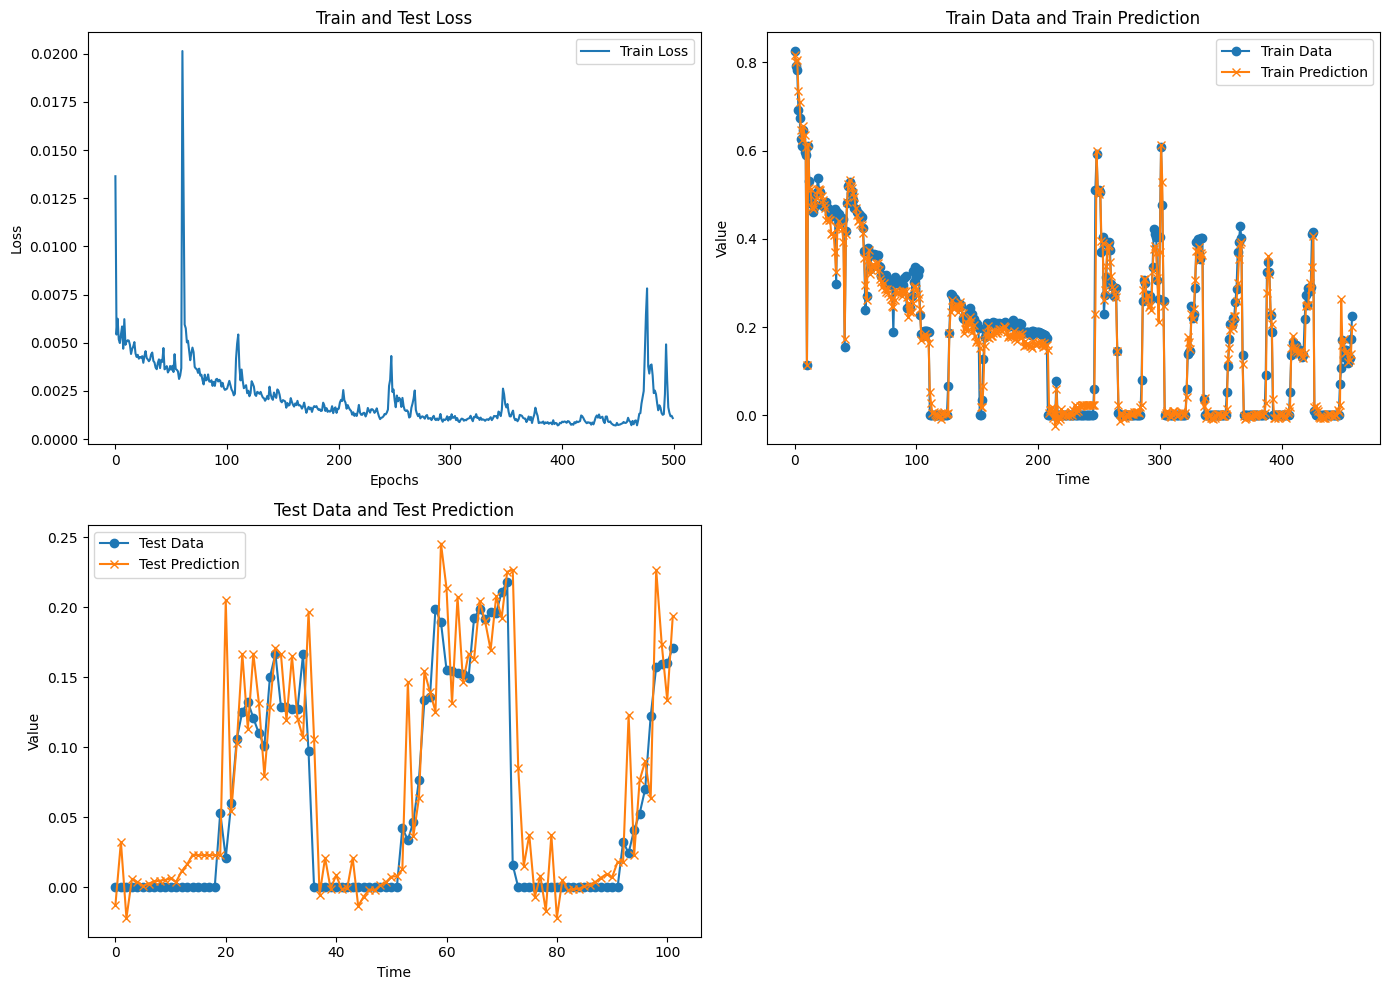

In [33]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

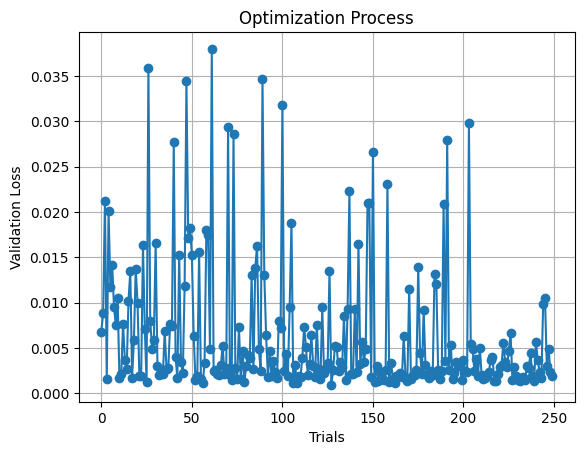

In [34]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

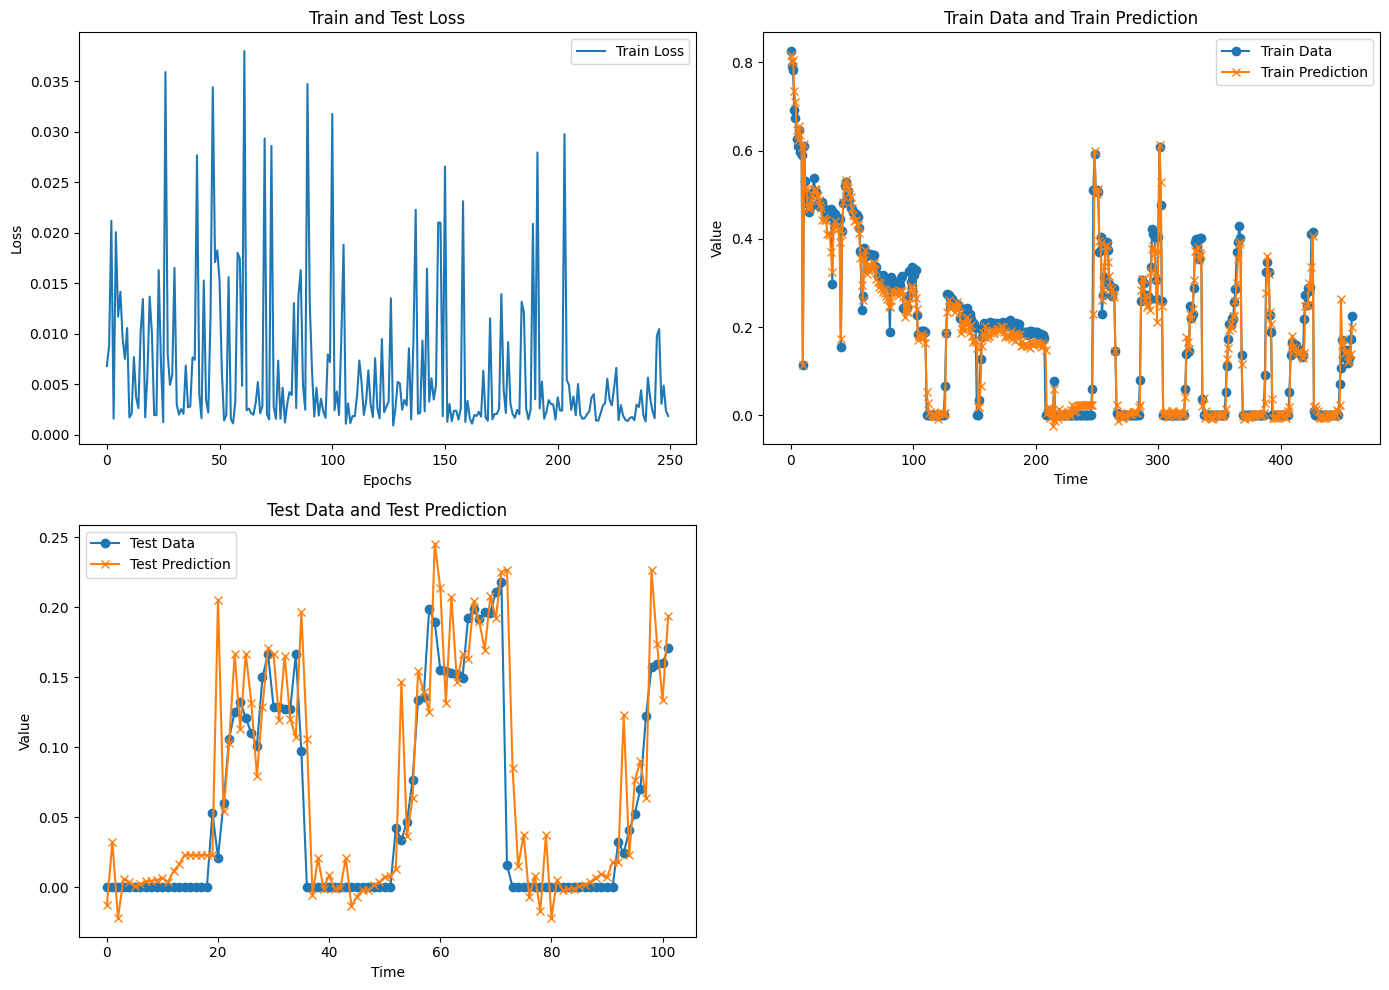

In [35]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

### Agora vamos criar o modelo com a melhor solução

In [36]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [37]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [38]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [39]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [40]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [41]:
# from keras.utils.vis_utils import plot_model


In [42]:
# plot_model(model_LSTM)

In [43]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [44]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [45]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.0062079105187290776
Test MSE: 0.0008711965290941013


In [46]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [47]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.000821  0.001799
1  Baseline   0.006208  0.000871


In [48]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [49]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'window_size': 28, 'batch_size': 15, 'n_lstm_layers': 7, 'lstm_units': 147, 'learning_rate': 0.0005640166351336888, 'Dropout_rate': 0.28801731925455754}
Trial 2: {'window_size': 46, 'batch_size': 6, 'n_lstm_layers': 15, 'lstm_units': 252, 'learning_rate': 0.002409405141710269, 'Dropout_rate': 0.15087672717688203}
Trial 3: {'window_size': 10, 'batch_size': 8, 'n_lstm_layers': 17, 'lstm_units': 43, 'learning_rate': 0.006199655606546731, 'Dropout_rate': 0.44541135311754254}
Trial 4: {'window_size': 57, 'batch_size': 16, 'n_lstm_layers': 4, 'lstm_units': 33, 'learning_rate': 0.0031640726407504358, 'Dropout_rate': 0.24461032061955576}
Trial 5: {'window_size': 24, 'batch_size': 14, 'n_lstm_layers': 10, 'lstm_units': 41, 'learning_rate': 0.0038176559470374616, 'Dropout_rate': 0.49416768501818564}
Trial 6: {'window_size': 58, 'batch_size': 9, 'n_lstm_layers': 10, 'lstm_units': 139, 'learning_rate': 0.0001234178824085396, 'Dropout_rate': 0.318